# Solving the Inverse Scattering problem using PDE constrained optimization

We want to solve using what is often referred as the near-field map

We start by loading all the necessary libraries

In [1]:
# to import the library without installing it
import context

import numpy as np
import scipy as sp

import matplotlib

import matplotlib.pyplot as plt
from functools import partial

from jax import jit

import jax
import jax.numpy as jnp
import time 
import jax.scipy.optimize

# this is the package to solve the lippman-Schwinger equation
import jax_ls

We define the size of the domain, in this case we consider the domain of interest
$$\Omega = [-0.5, 0.5] \times [-0.5, 0.5]$$
along with number of deegres of freedom in each direction and the frequency

In [2]:
# size of the domain in x and y
ax = 1.0
ay = 1.0

# number of discretization points per dimension
n = 2**6
m = n

# we choose to have 4 points per wavelenght
omega = 2*jnp.pi*(n//8)

# grid spacing
hx = 1/(n-1)

sampling_radious = 1.0
n_angles = n

We store all the information in a special tuple, which contains all the parameters necessary

In [3]:
# initialize the parameters
params_nf = jax_ls.init_params_near_field(ax, ay, n, m,\
                                         sampling_radious,\
                                         n_angles, omega)

We define and sample the perturbation that we want to reconstruct. In this case it just two Gaussian bumps.

In [4]:
# definition of the perturbation by the lense
@jit
def perturbation(x,y):
    return    1.0*jnp.exp(-500*(jnp.square(x+0.1) + jnp.square(y+0.2)))\
            + 1.0*jnp.exp(-500*(jnp.square(x-0.1) + jnp.square(y-0.1)))\
            + 1.0*jnp.exp(-500*(jnp.square(x-0.15) + jnp.square(y+0.3)))

# we sample the perturbation
nu = perturbation(params_nf.ls_params.X, params_nf.ls_params.Y) 
nu_vect = jnp.reshape(nu, (-1,))

Let's take a quick look at the perturbation that we want to reconstruct

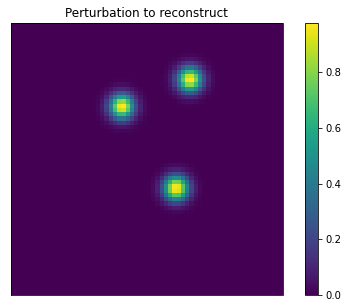

In [5]:
plt.figure(figsize=(8,5))
plt.imshow(jnp.real(nu_vect).reshape((n,n)))
plt.xticks([]); plt.yticks([]);
plt.title('Perturbation to reconstruct', color='black')
plt.colorbar()

### Generating the data

We define the near field map, and we produce our data.
The data itself is represented by a forward operator defined as 
$$\mathcal{F}[\nu]$$
acting on $\nu$, which corresponds to a compactly supported perturbation of an otherwise constant background media. In particular the forward map corresponds to the impulse response of the perturbation $\nu$ to a probing wave. 

In particular the equation satisfied is 
$$\Delta u+ \omega^2 (1 + \nu) u = -\omega^2 \nu u_i $$
where $u_i$ is the probing wave impinging on the perturbation $\nu$ and $u_s$ is the scattered wave, which also needs to satisfy the Sommerfeld conditions as infinity.

In this context, there are several ways to choose the probing wave, however, the most used alternatives are either
- a plane wave $u_i(\mathbf{x}) = e^{i\omega \mathbf{s} \cdot \mathbf{x}}$, where $\mathbf{s}$ is the incoming direction, or
- a point source  $u_i(\mathbf{x}) = \frac{i}{4} H^{(1)}_0(\omega | \mathbf{x}-\mathbf{s}|)$,where $\mathbf{s}$ is the location of the source. 

In this case we choose the later, and we let the incident wave to be idexed by $\mathbf{s}$ which for simplicity lies in $\mathbb{S}$.

For each incoming wave  $u_i^{\mathbf{s}}$ we solve the Helmholtz equation, 
$$\left \{ \begin{array}{l} \Delta u^{\mathbf{s}}+ \omega^2 (1 + \nu) u^{\mathbf{s}} = -\omega^2 \nu u_i^{\mathbf{s}} \\
                            \partial_r u^{\mathbf{s}} - i\omega u^{\mathbf{s}} = \mathcal{O}(r^{-1/2})
                            \end{array} \right .
$$

the solution is then sampled in a circle around the $\nu$, i.e. $u^{\mathbf{s}}(\mathbf{r})$ for $\mathbf{r} \in \mathbb{S}$. 

Therefore the near field maps can be indexed by $\mathbf{r}, \mathbf{s} \in \mathbb{S}$ such that 

$$ \left( F[\nu] \right)_{\mathbf{r},\mathbf{s}} = u^{\mathbf{s}}(\mathbf{r})$$ 


<img src="images/near_field_sketch.png" width=500 height=500 />

In [6]:
# jitting the near field map (vectorized) with the custom vjp
near_field_vjp = jit(partial(jax_ls.near_field_map_vect_vjp, params_nf))

# reference wavefield (i.e. data)
data_near_field = near_field_vjp(nu_vect)

We plot the near field, which consists in the data we want to fit

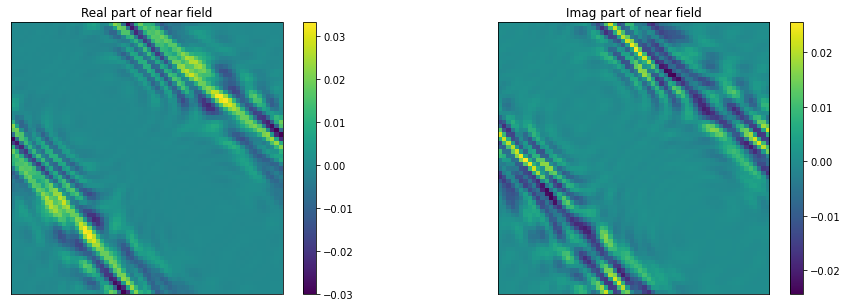

In [7]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.imshow(jnp.real(data_near_field).reshape((n,n)))
plt.xticks([]); plt.yticks([]);
plt.title('Real part of near field', color='black')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(jnp.imag(data_near_field).reshape((n,n)))
plt.xticks([]); plt.yticks([]);
plt.title('Imag part of near field', color='black')
plt.colorbar()

### Defining the minimization problem

Now we define the loss with respect to a arbitrary perturbation

$$ \ell(\nu) = \frac{1}{2}\| \mathcal{F}[\nu] - D \|^2_{L^2}$$

In this case $D$ is the data generated above.

In [8]:
# jitting the near field map (vectorized) with the custom vjp
loss_vjp = jit(partial(jax_ls.near_field_l2_loss, params_nf, data_near_field.reshape((m,n))))

We have defined the gradient using the custom_vjp interface, this can be easily computed using adjoit state methods

In [9]:
nabla_loss = jit(jax.grad(loss_vjp))

grad_loss_0 = nabla_loss(jnp.zeros(*nu_vect.shape))

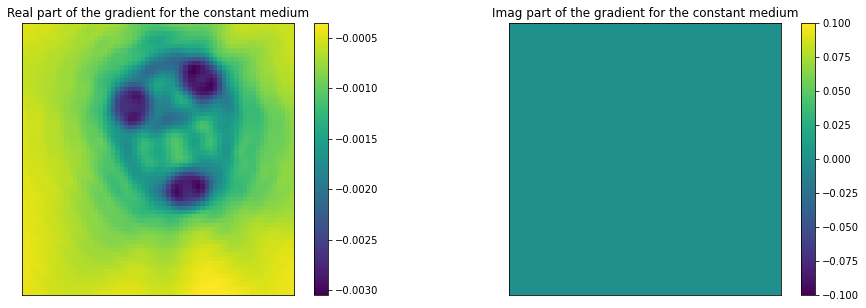

In [10]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.imshow(jnp.real(grad_loss_0).reshape((n,n)))
plt.xticks([]); plt.yticks([]);
plt.title('Real part of the gradient for the constant medium', color='black')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(jnp.imag(grad_loss_0).reshape((n,n)))
plt.xticks([]); plt.yticks([]);
plt.title('Imag part of the gradient for the constant medium', color='black')
plt.colorbar()

We run the PDE constrained optimization starting with a zero initial guess.

We start with computing the loss with the zero initial guess.

initial loss with zero initial guess 1.541645e-01


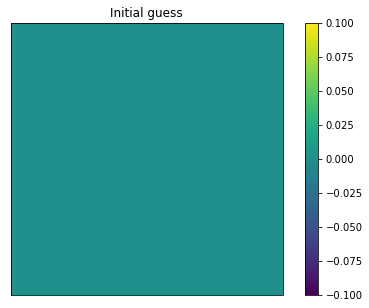

In [11]:
# initial guess
nu_0 = jnp.zeros(*nu_vect.shape)

plt.figure(figsize=(8,5))
plt.imshow(jnp.real(nu_0).reshape((n,n)))
plt.xticks([]); plt.yticks([]);
plt.title('Initial guess', color='black')
plt.colorbar()

# initial loss (we trigged the compilation)
print("initial loss with zero initial guess %e"%(loss_vjp(nu_0)))

We run the optimization algorithm (in this case only BFGS is implemented in Jax), and we time it (it takes around 40s in a RTX A6000)

In [12]:
%%time 
opt_result = jax.scipy.optimize.minimize(loss_vjp, x0=nu_0, method="bfgs")

opt_nu = opt_result.x

CPU times: user 1min 16s, sys: 391 ms, total: 1min 16s
Wall time: 43.9 s


In [13]:
# printing the number of evaluations
print("Number of function evaluations %d"%(opt_result.nfev))
print("Number of gradient evaluations %d"%(opt_result.njev))

Number of function evaluations 87
Number of gradient evaluations 87


We check the final loss, it should be around $10^{-6}$. 

In [14]:
print("Final loss with zero initial guess %e"%(loss_vjp(opt_nu)))

Final loss with zero initial guess 9.674923e-07


We check the error of the reconstruction compared to the ground-truth

In [15]:
print("Relative Error in the reconstruction %e"%(jnp.linalg.norm(nu_vect - opt_nu)/jnp.linalg.norm(nu_vect)))

Relative Error in the reconstruction 1.044063e-02


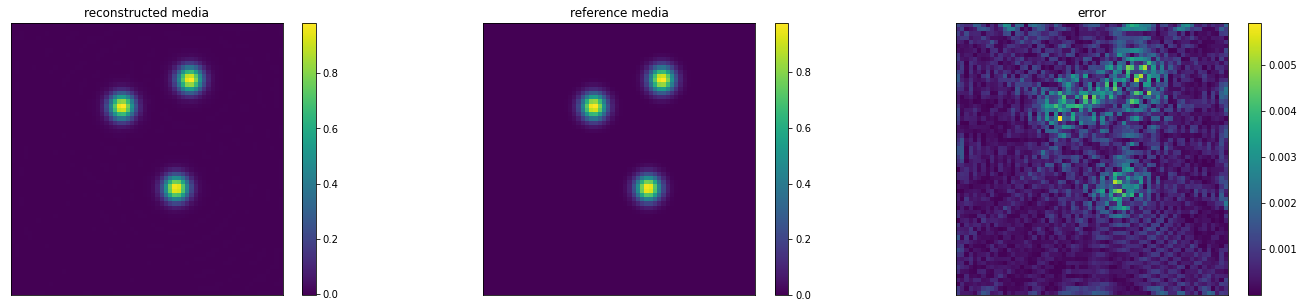

In [16]:
# ploting the near field map 
plt.figure(figsize=(24,5))
plt.subplot(1, 3, 1)
plt.imshow(jnp.real(opt_nu).reshape((n,n)))
plt.xticks([]); plt.yticks([]);
plt.title('reconstructed media', color='black')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(jnp.real(nu_vect).reshape((n,n)))
plt.xticks([]); plt.yticks([]);
plt.title('reference media', color='black')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(jnp.abs(nu_vect-opt_nu).reshape((n,n)))
plt.xticks([]); plt.yticks([]);
plt.title('error', color='black')
plt.colorbar()